64 64


C:\Users\yurid\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


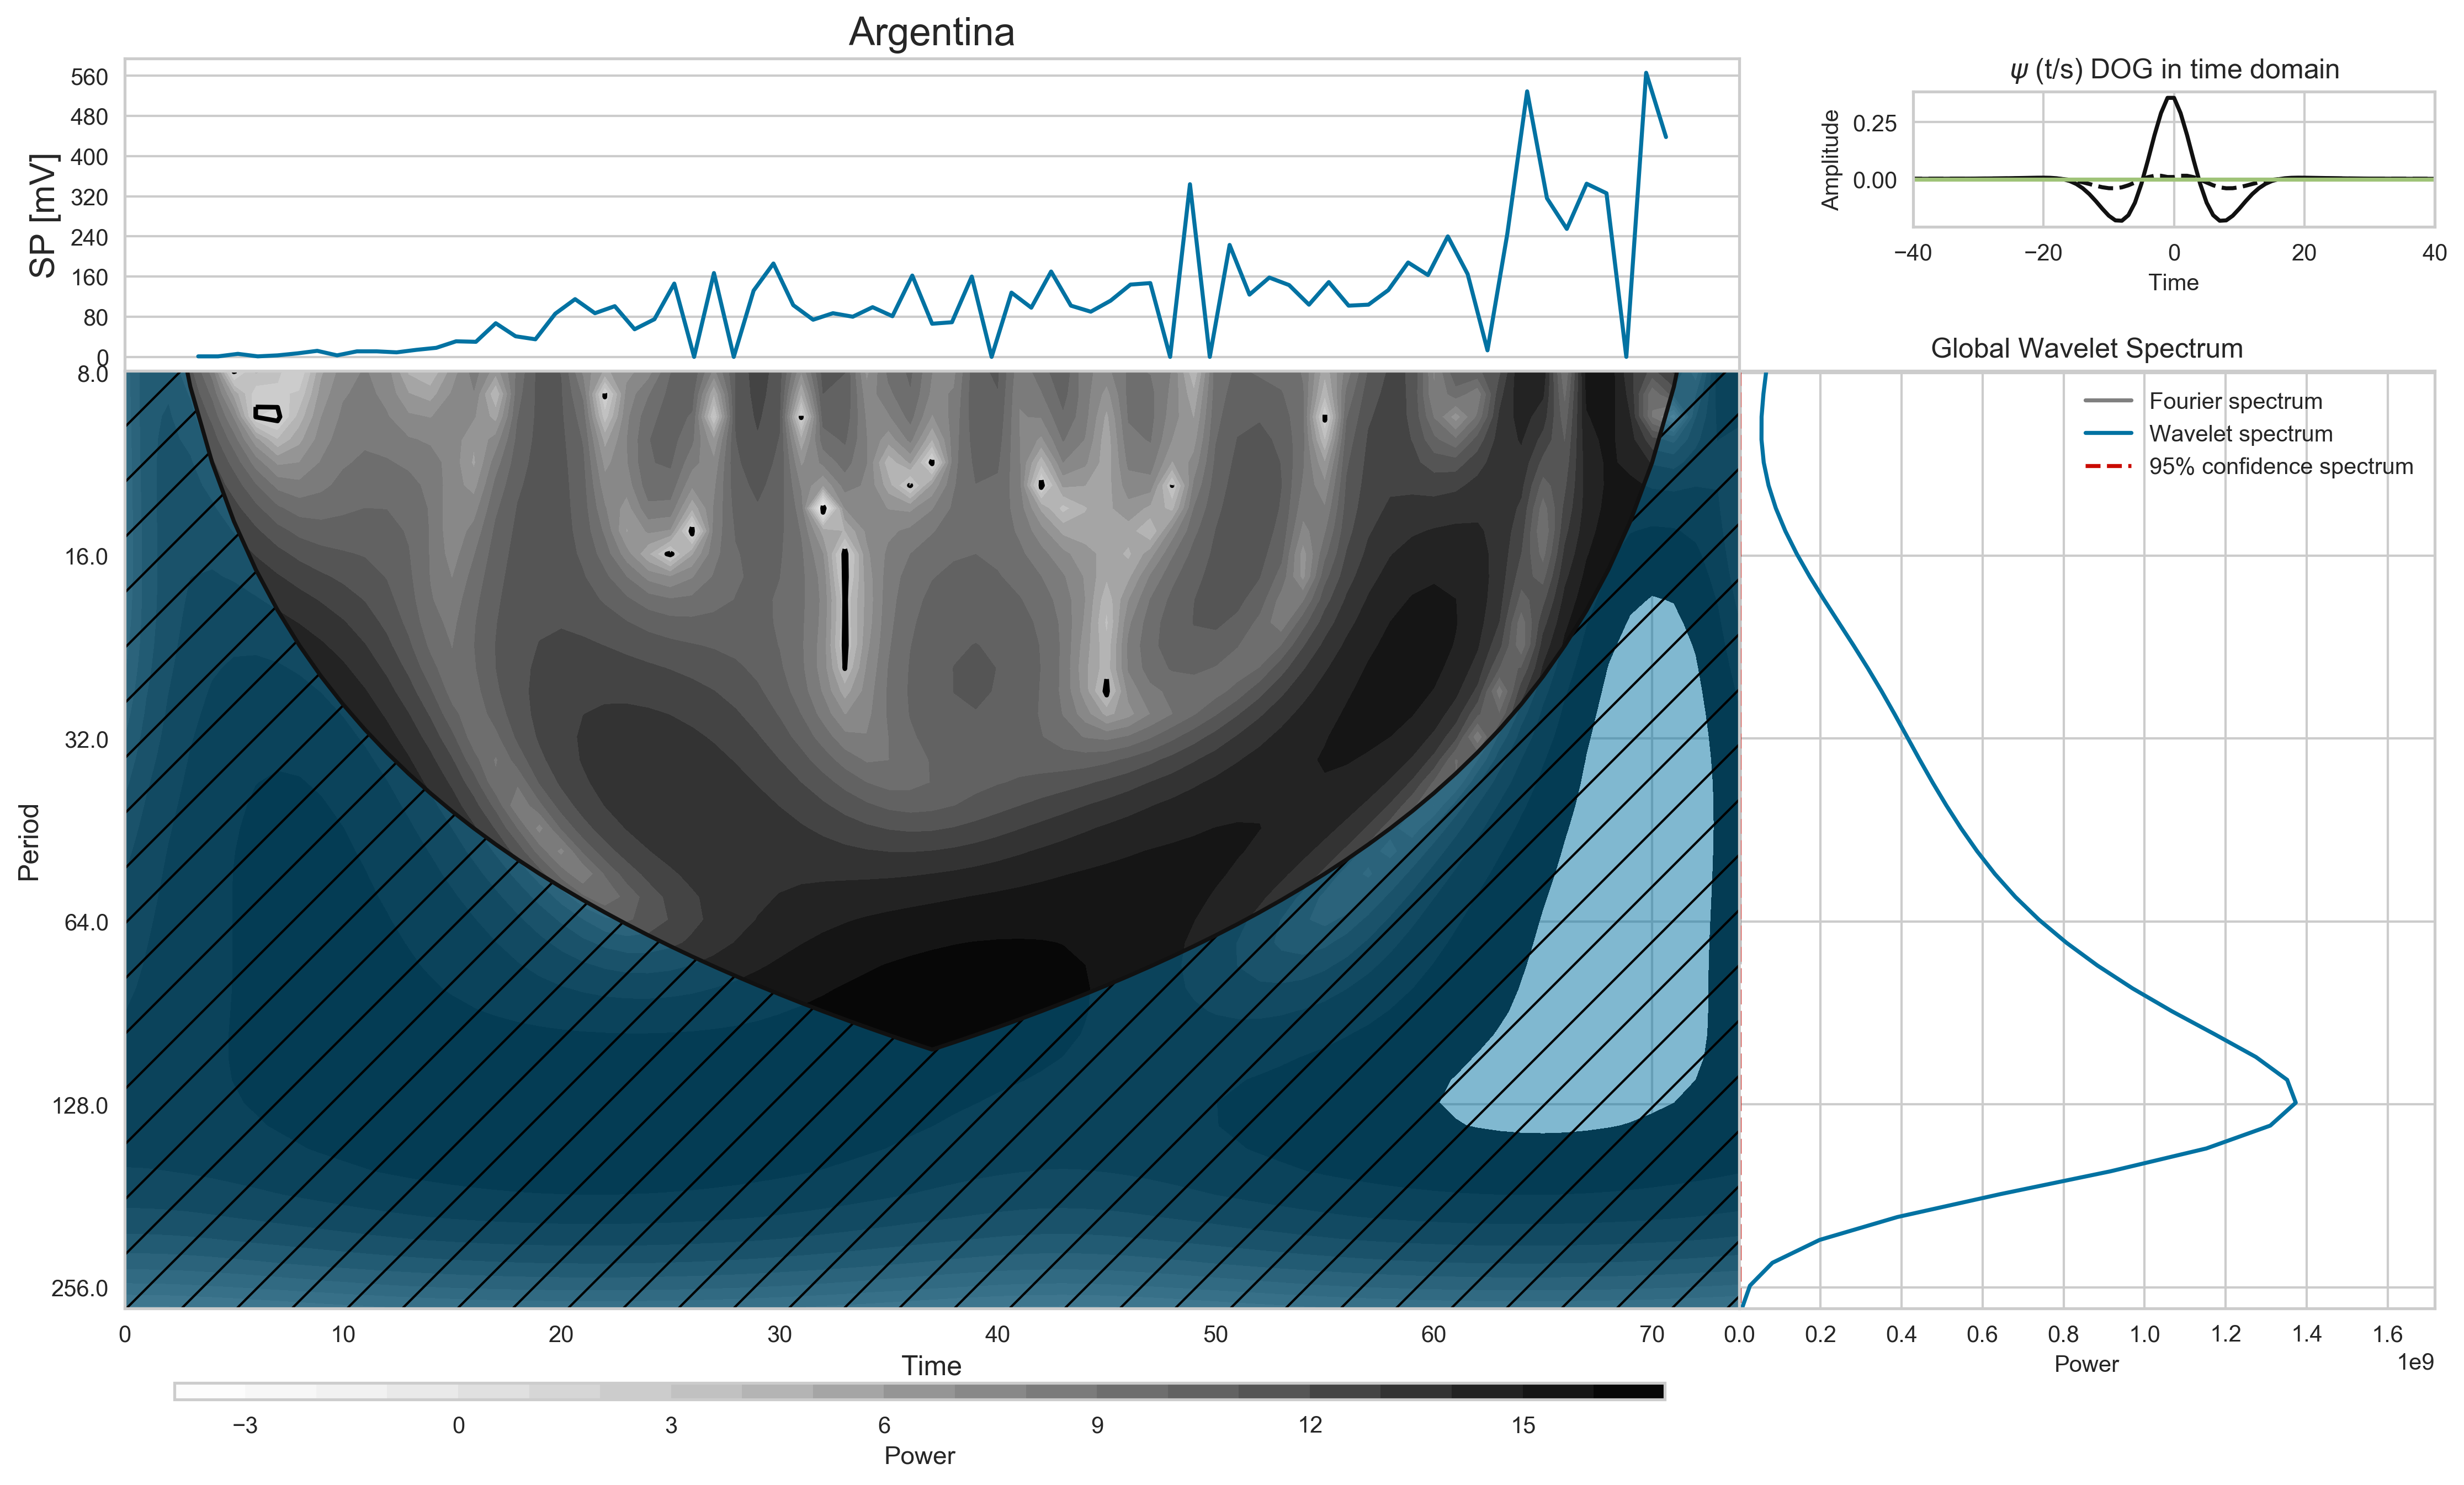

C:\Users\yurid\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
C:\Users\yurid\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


TypeError: cannot unpack non-iterable numpy.float64 object

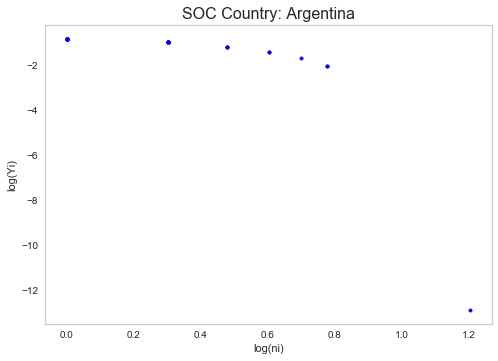

In [12]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsfuncs
import mfdfa
import waipy

def SOC(data, title, n_bins=50):
    n = len(data)
    mean = np.mean(data)
    var = np.var(data)
    Gamma = []
    
    for i in range(0,n): 
        Gamma.append((data[i] - mean)/var)    
    
    counts, bins = np.histogram(Gamma, n_bins)
    Prob_Gamma = []
    for i in range(0, n_bins):
        Prob_Gamma.append(counts[i]/n) #plt.plot(Gamma)    
    log_Prob = np.log10(Prob_Gamma) 
    p = np.array(Prob_Gamma)
    p = p[np.nonzero(p)]
    c = counts[np.nonzero(counts)] 
    log_p = np.log10(p)
    a = (log_p[np.argmax(c)] - log_p[np.argmin(c)]) / (np.max(c) - np.min(c)) 
    b = log_Prob[0]
    y = b * np.power(10, (a*counts))
        
    plt.clf()
    plt.scatter(np.log10(counts), y, marker=".", color="blue")
    plt.title('SOC Country: {}'.format(title), fontsize = 16) 
    plt.xlabel('log(ni)')
    plt.ylabel('log(Yi)') 
    plt.grid()
    # plt.show() 

namefile="daily-cases-covid-19.csv"
l=pd.read_csv(namefile)
codes=list(set(l["Entity"]))
codes=codes[1:]
l=l.set_index("Entity")
values=[]
countries=["Argentina", "New Zealand", "France", "Turkey", "Spain" ]
for i in codes:
    y=list(l.filter(like=i, axis=0)["Daily confirmed cases (cases)"])
    if i in countries:
        result=waipy.cwt(y, 1, 1, 0.125, 2, 4/0.125, 0.72, 6, 'DOG', "x")
        waipy.wavelet_plot(i, range(len(y)), y, 0.03125, result, savefig=True)
    if len(y) > 50:
        SOC(y, i)
        alfa,xdfa,ydfa, reta = statsfuncs.dfa1d(y,1)
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = statsfuncs.psd(y)
        a,b,c=mfdfa.makemfdfa(y)
        values.append([statsfuncs.variance(y), statsfuncs.skewness(y), statsfuncs.kurtosis(y), alfa, index, a, i])
plt.show()
skew2=[]
alfa=[]
kurt=[]
index=[]
psi=[]

for i in range(len(values)):
    skew2.append(values[i][1]**2)
    kurt.append(values[i][2])
    alfa.append(values[i][3])
    index.append(values[i][6])

skew2=np.array(skew2)
alfa=np.array(alfa)
kurt=np.array(kurt)

kk=pd.DataFrame({'Skew²': skew2, 'Alpha': alfa})
K=20
model1=KMeans()
visualizer = KElbowVisualizer(model1, k=(1,K))
kIdx=visualizer.fit(kk)      
visualizer.show()        
kIdx=kIdx.elbow_value_
model1=KMeans(n_clusters=kIdx).fit(kk)
# scatter plot
ax = plt.figure()
cmap = plt.get_cmap('gnuplot')
clr = [cmap(i) for i in np.linspace(0, 1, kIdx)]
for i in range(0,kIdx):
    ind = (model1.labels_==i)
    plt.scatter(skew2[ind],alfa[ind], s=30, c=clr[i], label='Cluster %d'%i)

plt.xlabel("Skew²")
plt.ylabel("Alfa")
plt.title('KMeans clustering with K=%d\n All countries with >50 days' % kIdx)
plt.legend()
plt.savefig("covids2xalfaclusters.png")
plt.show()

kk=pd.DataFrame({'Skew²': skew2,'Alpha': alfa,'Cluster skew²': model1.labels_}, index=index)
kk=kk.sort_values(by=["Cluster skew²"])
kk.to_csv("sort_by_skew.csv")

kk=pd.DataFrame({'Kurtosis': kurt, 'Alpha': alfa})
K=20
model2=KMeans()
visualizer = KElbowVisualizer(model2, k=(1,K))
kIdx=visualizer.fit(kk)        
visualizer.show()       
kIdx=kIdx.elbow_value_
model2=KMeans(n_clusters=kIdx).fit(kk)
# scatter plot
ax = plt.figure()
cmap = plt.get_cmap('gnuplot')
clr = [cmap(i) for i in np.linspace(0, 1, kIdx)]
for i in range(0,kIdx):
    ind = (model2.labels_==i)
    plt.scatter(kurt[ind],alfa[ind], s=30, c=clr[i], label='Cluster %d'%i)

plt.xlabel("Kurtosis")
plt.ylabel("Alfa")
plt.title('KMeans clustering with K=%d\n All countries with >50 days' % kIdx)
plt.savefig("covidkxalfaclusters.png")
plt.legend()
plt.show()

kk=pd.DataFrame({'Kurt': kurt,'Alpha': alfa,'Cluster kurt': model2.labels_}, index=index)
kk=kk.sort_values(by=["Cluster kurt"])
kk.to_csv("sort_by_kurt.csv")

skew2=[]
alfa=[]
kurt=[]
index=[]
psi=[]

for i in range(len(values)):
    if not np.isnan(values[i][5]):
        skew2.append(values[i][1]**2)
        psi.append(values[i][5])
        index.append(values[i][6])
    else:
        print("Excluded country: {}".format(values[i][6]))
        
skew2=np.array(skew2)
psi=np.array(psi)

kk=pd.DataFrame({'Skew²': skew2, 'Psi': psi})
K=20
model3=KMeans()
visualizer = KElbowVisualizer(model3, k=(1,K))
kIdx=visualizer.fit(kk)       
visualizer.show()        
kIdx=kIdx.elbow_value_
model3=KMeans(n_clusters=kIdx).fit(kk)
# scatter plot
ax = plt.figure()
cmap = plt.get_cmap('gnuplot')
clr = [cmap(i) for i in np.linspace(0, 1, kIdx)]
for i in range(0,kIdx):
    ind = (model3.labels_==i)
    plt.scatter(skew2[ind],psi[ind], s=30, c=clr[i], label='Cluster %d'%i)

plt.xlabel("Skew²")
plt.ylabel("Psi")
plt.title('KMeans clustering with K=%d\n With some excluded countries' % kIdx)
plt.legend()
plt.savefig("covids2xpsiclusters.png")
plt.show()



kk=pd.DataFrame({'Skew²': skew2,'Psi': psi,'Cluster psi': model3.labels_}, index=index)
kk=kk.sort_values(by=["Cluster psi"])
kk.to_csv("sort_by_psi.csv")